In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from chewc.core import *
from chewc.trait import *
from chewc.meiosis import *
from chewc.cross import *


import torch
import attr
import matplotlib.pyplot as plt


# ChewC

> Pytorch Breeding

In short, this will be a GPU-enabled stochastic simulation for breeding programs with an emphasis on cost-benefit-analysis for novel breeding tools and creating a suitable interface for RL agents.


---
We will also incorporate an emphasis on budget and costs associated with each action to manage long-term breeding budgets. As well as model theoretical tools in the plant breeder's toolbox. e.g.

> a treatment which increases crossover rates

> a treatment which reduces flowering time

> a treatment which enables gene drive at select loci

Each treatment will cost $$ ultimately helping guide the implementation in real-world breeding programs.


## Install

```sh
pip install chewc
```

## How to use

First, define the genome of your crop

In [ ]:
import torch

ploidy = 2
n_chr = 10
n_loci = 100
n_Ind = 3330
g = Genome(ploidy, n_chr, n_loci)
population = Population()
population.create_random_founder_population(g, n_founders=n_Ind)
init_pop = population.get_dosages().float()  # gets allele dosage for calculating trait values

# multi_traits


target_means = torch.tensor([0, 5])
target_vars = torch.tensor([1, 1])  # Note: I'm assuming you want a variance of 1 for the second trait
correlation_values = [
        [1.0, 0.8],
        [0.8, 1.0],
    ]


correlated_traits = corr_traits(g, init_pop, target_means, target_vars, correlation_values)

Created genetic map


In [ ]:
current_pop = init_pop

In [ ]:
new_parents = population.get_genotypes().float()
means = []
for i in range(10):
    curr_pop = random_crosses(g, new_parents, 200)
    new_pheno = correlated_traits[0](curr_pop.sum(dim=1))
    means.append(new_pheno.mean())
    topk = torch.topk(new_pheno,10) # select  top 50 parents
    new_parents = curr_pop.float()[topk.indices]

<matplotlib.collections.PathCollection>

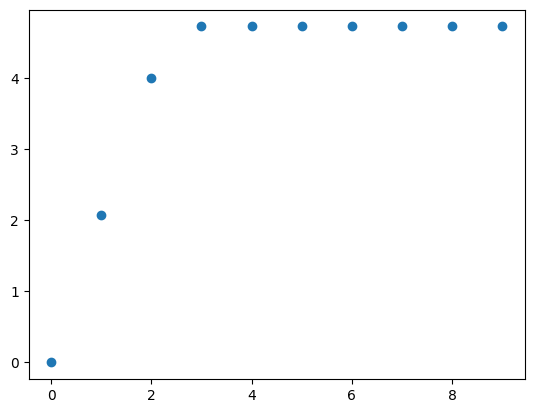

In [ ]:
plt.scatter(range(len(means)),means)

<matplotlib.collections.PathCollection>

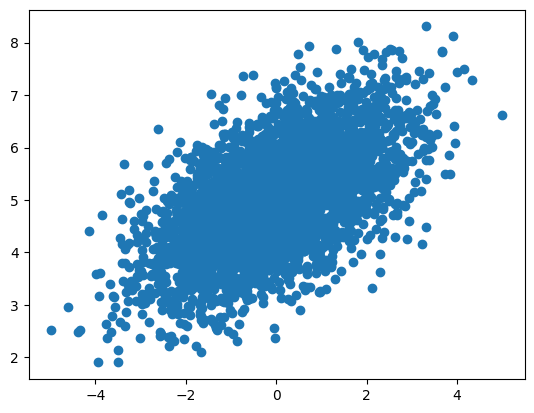

In [ ]:
plt.scatter(correlated_traits[0](init_pop,h2=.5),correlated_traits[1](init_pop,h2=1))